# Scale-down design documentation

In [46]:
from cmodels.sc_cmodel import sc_cmodel
from cmodels.sc_cmodel_sol import sc_cmodel_sol

from mmodels.monod_bb.sc_monod_bb import sc_monod_bb
from mmodels.monod_bb.im_monod_bb import im_monod_bb

from sd_design.ifr_sd.monod_bb_cstarv.ifr_sd_monod_bb_cstarv import ifr_sd_monod_bb_cstarv
from sd_design.ifr_sd.monod_bb_cstarv.ifr_sd_monod_bb_cstarv_sc_panel import ifr_sd_monod_bb_cstarv_sc_panel

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Define the compartment model's process settings

In [48]:
STR_BS_cmod = sc_cmodel(excel_path="cmodels/cmodel_files/STR_4_cm/compmap_4cm.xlsx", N_rpm=140, Fg=0.79, p_head=1)

### Print kla to compare with excel sheet calculations

In [49]:
STR_BS_cmod.calc_sc_cmodel()

[array([[      0.        , 2126700.1416517 ,       0.        ,
               0.        ],
        [2126700.1416517 ,       0.        , 2206130.66655656,
               0.        ],
        [      0.        , 2206130.66655656,       0.        ,
         2281141.07568133],
        [      0.        ,       0.        , 2281141.07568133,
               0.        ]]),
 array([26.08883008, 17.17401309, 17.31086881, 17.43037468]),
 array([0.13651961, 0.18416405, 0.18425818, 0.18439461]),
 array([2.24301017, 2.48198177, 2.72095336, 2.95992496]),
 array([1., 0., 0., 0.]),
 array([348.05206599, 278.27553211, 290.29488082, 301.75661193])]

In [50]:
STR_BS_cmod.kLa

array([0.13651961, 0.18416405, 0.18425818, 0.18439461])

In [51]:
STR_BS_cmod.VL

array([26.08883008, 17.17401309, 17.31086881, 17.43037468])

In [52]:
STR_BS_cmod.vg_s

array([0.03229175, 0.02918262, 0.02661962, 0.02447046])

In [53]:
STR_BS_cmod.Ps

array([29017.78054072, 30155.86447262, 31227.86817456, 32242.96609777])

## Define parameters for the metabolic models of both strains

In [54]:
WT_mmodel = sc_monod_bb(
    strain_id='DDB35',
    strain_description= 'WT E. coli'
    )

mu_max = 0.4 # 0.34 # it was later found that this is the actual µmax in mabr 
Ysx = 0.5
qS_max = 0.8 # 0.68 # hence, also qSmax must change
Ks = 0.05
Yso = 14 
Ko = 0

WT_mmodel.define_strain_params(qS_max,Ysx,Ks,Yso,Ko)

### WT E. coli

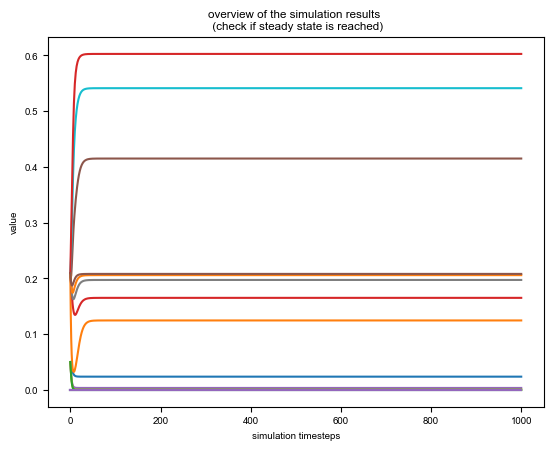

In [55]:
# initial values for one compartment
y0_1d = [
    0.05, #S 
    0.2095, #O
    0, #A
    0.2095 #yO
    ]

# multiply initial values with the number of compartments
y0 = y0_1d*STR_BS_cmod.n_comps
# simulation time
t_eval=np.linspace(0,1,1001)
# Biomass concentration 
X = 40 # to keep things consistent: A biomass concentration of 40 g/L was chosen for Ys = 0.5; hence Ysx = 0.52 should result in 41.6. This is to keep the glucose feed rate constant accross different examples. 
# Growth rate for the fed-batch
mu_set = 0.05
# Liquid volume in the whole reactor
VL = STR_BS_cmod.calc_sc_cmodel()[1].sum()
# Biomass yield
Ysx = WT_mmodel.Ysx
# Glucose feed rate
Fs_feed_WT = mu_set/Ysx*X*VL*1000
# compartment model instance
cmodel = STR_BS_cmod

# create a solution object
WT_sol = sc_cmodel_sol(y0, t_eval, WT_mmodel, cmodel, X, Fs_feed_WT)

In [56]:
VL

78.00408666040909

In [57]:
Fs_feed_WT

312016.34664163634

In [58]:
# Display solution
WT_sol.sol_df

,S,O,A,yO,qS,mu,O_star,OTR,qO,comp_id,liquid_vol [L]
0,0.023770,0.124520,0.0,0.165004,0.257771,0.128885,0.370105,120.697822,3.608787,1,26.088830
1,0.003541,0.414686,0.0,0.197079,0.052915,0.026457,0.489147,49.366675,0.740807,2,17.174013
2,0.000519,0.540780,0.0,0.205715,0.008213,0.004106,0.559742,12.578313,0.114978,3,17.310869
3,0.000088,0.602175,0.0,0.207933,0.001408,0.000704,0.615467,8.823587,0.019717,4,17.430375


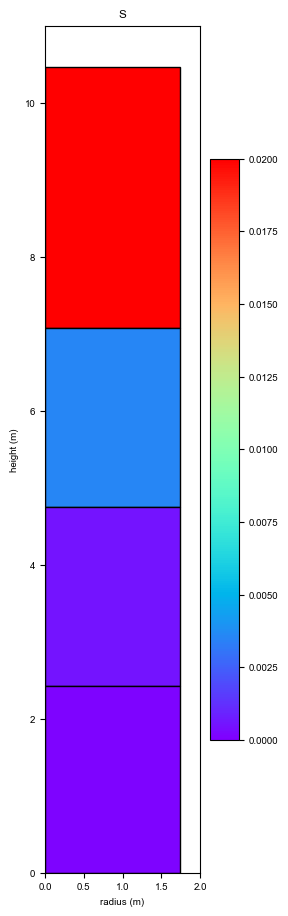

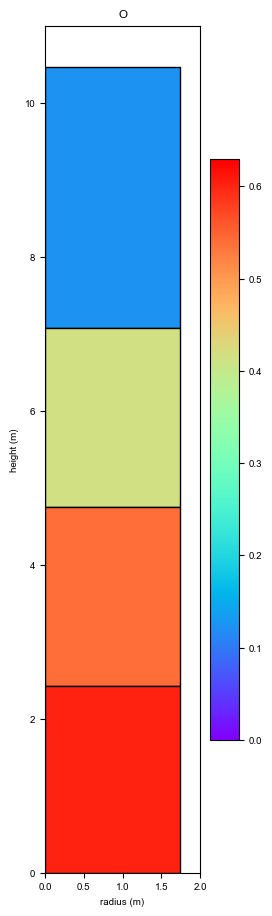

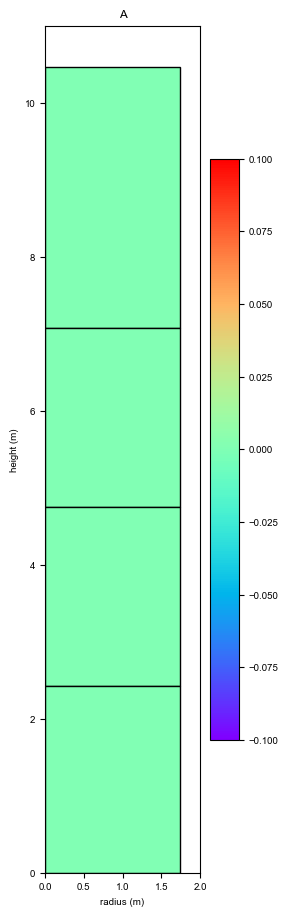

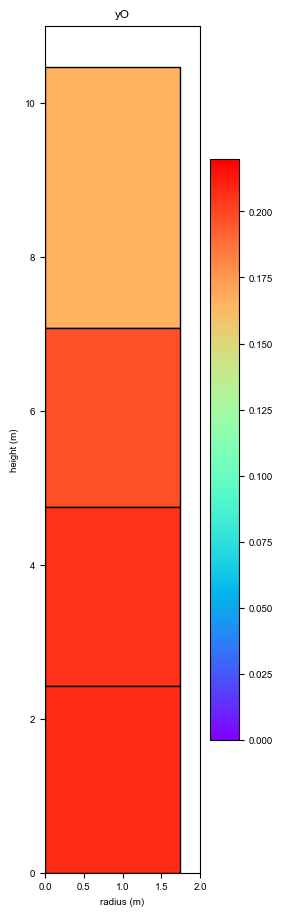

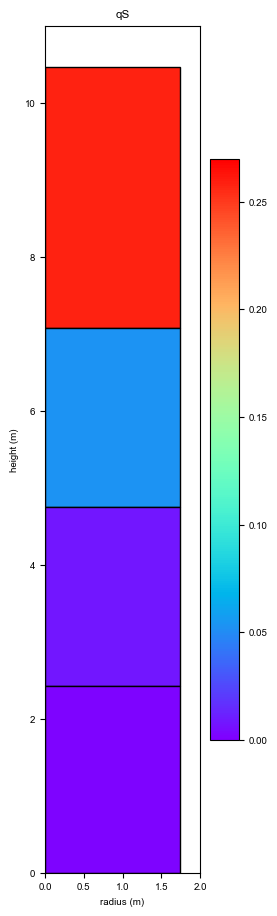

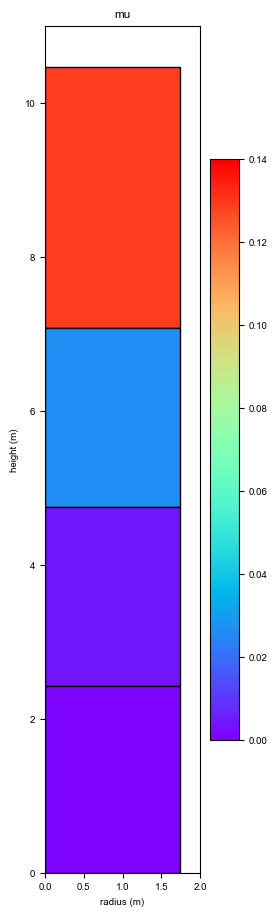

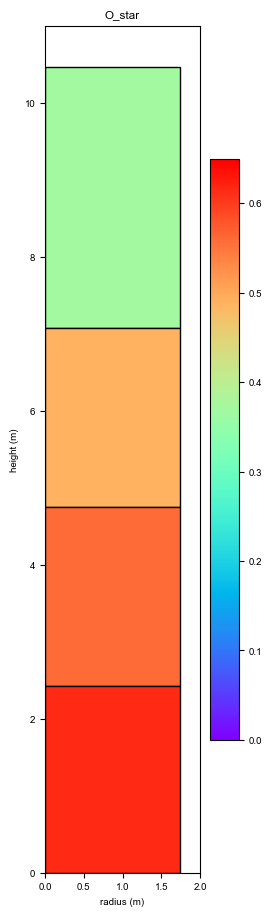

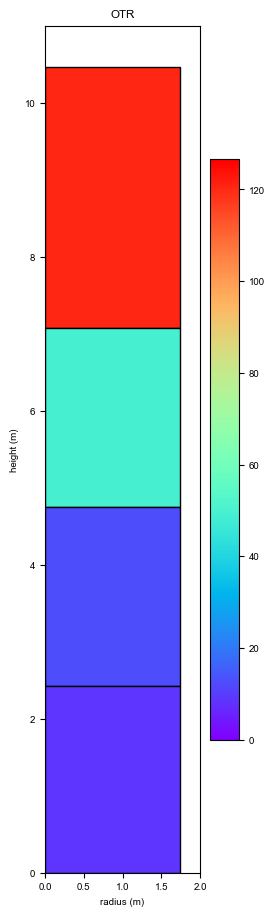

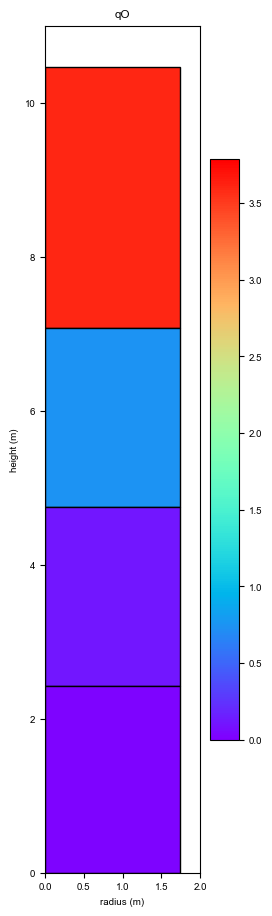

In [59]:
# Plot compartment map
WT_sol.plot_solution()

# Figure creation

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

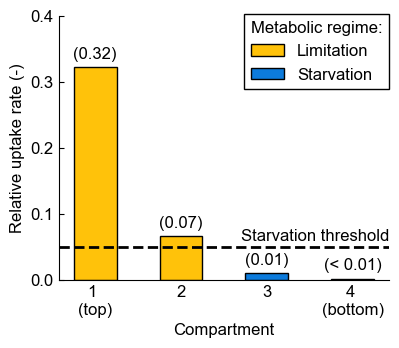

In [61]:
# formatting
plt.rcParams['font.size'] = 12
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams["legend.markerscale"] = 1

params = {'mathtext.default': 'regular' }       
plt.rcParams.update(params)

# figure size
height_cm = 8.5
width_cm = 10

fig, axs = plt.subplots(figsize=(width_cm/2.54,height_cm/2.54))

# width of the bars
barWidth = 0.5

bars = list(WT_sol.sol_df['qS']/WT_mmodel.qS_max)

# The x position of bars
r1 = np.arange(len(bars))
 
# Create blue bars
axs.bar(
    r1, 
    bars, 
    width = barWidth, 
    color = [matplotlib.colors.to_rgb('#FFC20A')+(1,),matplotlib.colors.to_rgb('#FFC20A')+(1,),matplotlib.colors.to_rgb('#0C7BDC')+(1,),matplotlib.colors.to_rgb('#0C7BDC')+(1,)], 
    edgecolor = 'black', 
    capsize=2
)
axs.text(r1[0],bars[0]+0.02,s="("+str(np.round(bars[0],2))+")",horizontalalignment='center',verticalalignment='center')
axs.text(r1[1],bars[1]+0.02,s="("+str(np.round(bars[1],2))+")",horizontalalignment='center',verticalalignment='center')
axs.text(r1[2],bars[2]+0.02,s="("+str(np.round(bars[2],2))+")",horizontalalignment='center',verticalalignment='center')
axs.text(r1[3],bars[3]+0.02,s="(< 0.01)",horizontalalignment='center',verticalalignment='center')

axs.set_xlim(axs.get_xlim()[0],axs.get_xlim()[1])
axs.hlines(y=0.05,xmin=axs.get_xlim()[0],xmax=axs.get_xlim()[1],colors='k',linestyles='--',linewidth=2)
axs.text(axs.get_xlim()[1],0.06,s='Starvation threshold',horizontalalignment='right',color='k')

# general layout
axs.set_xticks([0,1,2,3])
axs.set_xticklabels(['1 \n(top)','2','3','4 \n(bottom)'])
axs.tick_params(length=0,axis='x')
axs.set_xlabel('Compartment')
axs.set_ylabel('Relative uptake rate (-)')
axs.set_ylim(0,0.4)
axs.set_yticks([0,0.1,0.2,0.3,0.4])

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

axs.tick_params(direction='in')


# axs.set_title('Compartment model solution',loc='left',size=14,pad= 10);

legend_elements = [
    Patch(facecolor=matplotlib.colors.to_rgb('#FFC20A')+(1,), edgecolor='black',label='Limitation'),
    Patch(facecolor=matplotlib.colors.to_rgb('#0C7BDC')+(1,), edgecolor='black',label='Starvation')
]

plt.subplots_adjust(left=0.14,right=0.98,top=0.97,bottom=0.18);

leg = fig.legend(handles=legend_elements, fancybox=False,bbox_to_anchor=(1,1),loc='upper right',ncol=1, edgecolor='black',columnspacing=0.1,handletextpad=0.8,title='Metabolic regime:',framealpha=1);
leg._legend_box.align = "left"

# axs.set_ylim(0,0.1)
# axs.get_legend().remove()

## Pulse simulation 

### WT

In [70]:
im_WT_mmodel = im_monod_bb(
    strain_id='DDB7',
    strain_description= 'WT E. coli'
    )

qS_max = 0.8
Ysx = 0.5
Ks = 0.05
Yso = 14 # copied from the WT strain
Ko = 0

im_WT_mmodel.define_strain_params(qS_max,Ysx,Ks,Yso,Ko)

In [81]:
# ODE functions
func = im_WT_mmodel.im_bmodel_odes
# initial values

X = 40

y0 = [
    X,    # X [g/L]
    0,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]
# timesteps to evaluate
t_eval = np.linspace(0,150/3600,10001)

# process parameter function arguments
kla = 1000 # kla [1/h]
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 500 # Sf [g/L]
mu_set = 0.05 # mu_set [1/h]
V_fixed = True
X_fixed = True
pulse_cycle_time = 150 # [s]
pulse_on_ratio = 0.4 # [-]
D_set = mu_set/im_WT_mmodel.Ysx*X/Sf


# im_bmodel_odes(self,t,y,kla,pabs,yO,Sf:float,mu_set:float,V_fixed:bool=False,X_fixed:bool=False,pulse_cycle_time:float=None,pulse_on_ratio:float=None,returns:str='dydt'):
args_pulse=(kla,pabs,yO,Sf,mu_set,V_fixed,X_fixed,D_set,pulse_cycle_time,pulse_on_ratio,'dydt')

sol_WT_pulse = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args_pulse)

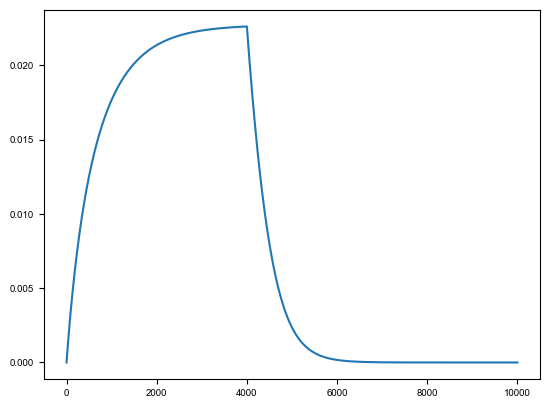

In [82]:
plt.plot(sol_WT_pulse[:,1]);

In [83]:
rates_WT_pulse = im_WT_mmodel.im_bmodel_odes(
    t=t_eval,
    y=sol_WT_pulse.T,
    kla=kla,
    pabs=pabs,
    yO=yO,
    Sf=Sf,
    mu_set=mu_set,
    V_fixed=V_fixed,
    X_fixed=X_fixed,
    returns='rates'
)

In [84]:
rates_WT_pulse

[['qS',
  array([0.00000000e+00, 6.65226475e-04, 1.32758311e-03, ...,
         6.37531738e-08, 6.35850279e-08, 6.34173532e-08])],
 ['mu',
  array([0.00000000e+00, 3.32613237e-04, 6.63791557e-04, ...,
         3.18765869e-08, 3.17925139e-08, 3.17086766e-08])],
 ['O_star', 0.2095],
 ['OTR',
  array([0.00000000e+00, 7.73759973e-04, 3.09018292e-03, ...,
         1.00095332e-04, 9.98333506e-05, 9.95719258e-05])],
 ['qO',
  array([0.00000000e+00, 9.31317065e-03, 1.85861636e-02, ...,
         8.92544433e-07, 8.90190391e-07, 8.87842945e-07])]]

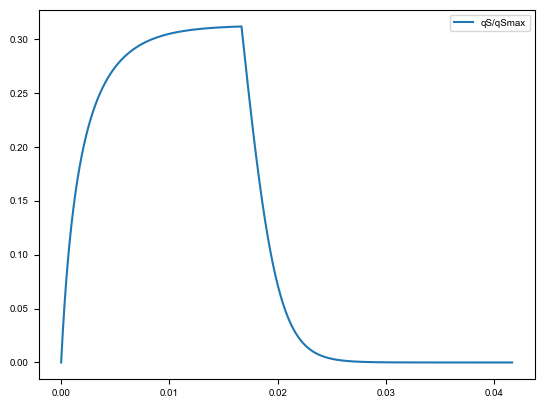

In [85]:
plt.plot(t_eval,(rates_WT_pulse[0][1])/0.8,label='qS/qSmax')
plt.legend();

## The starvation regime in intermittent feeding at different biomass concentrations

In [86]:
def starvation_fraction(relative_qS_values):
    not_starv = sum(relative_qS_values >= 0.05)
    starv = sum(relative_qS_values < 0.05)
    starv_frac = starv/(starv+not_starv)
    
    return starv_frac

## Pulse design figures

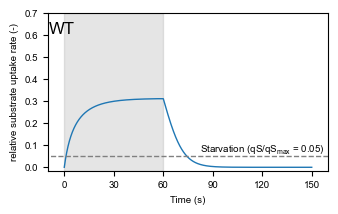

In [87]:
# formatting
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams["legend.markerscale"] = 0

# figure size
height_cm = 5
width_cm = 8.3
fig, ax1 = plt.subplots(figsize=(width_cm/2.54,height_cm/2.54))

ax1.plot(t_eval*3600, (rates_WT_pulse[0][1])/0.8,linewidth=1)
ax1.axvspan(0,60,color='grey', alpha=0.2)
ax1.hlines(y=0.05,xmin=-100,xmax=200,colors='grey',linewidth=1,linestyles='--')
ax1.annotate(text='Starvation (qS/$\mathregular{qS_{max}}$ = 0.05)',xy=(120,0.07),ha='center')

ax1.set_ylim(top=0.7)
ax1.set_ylabel('relative substrate uptake rate (-)')
ax1.set_xlim(-10,160)
ax1.set_xlabel('Time (s)')
ax1.set_xticks([0,30,60,90,120,150])

ax1.text(0.05, 0.9, 'WT', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes,fontsize=12)

plt.tight_layout(pad=0.3,h_pad=1.5)
# plt.savefig('../figures/IFR_design.png',dpi=600)